In [1]:
# !pip install mitiq
# !pip uninstall qiskit-terra -y
# !pip uninstall qiskit-machine-learning -y
# !pip uninstall qiskit-ibm-runtime -y
# !pip uninstall qiskit_aer -y
# !pip install qiskit-machine-learning qiskit-ibm-runtime qiskit-aer
# !pip install qiskit==1.1.2

In [1]:
import qiskit
import qiskit_machine_learning
import qiskit_ibm_runtime
import qiskit_aer

print('Qiskit Version :', qiskit.version.get_version_info())
print('Qiskit Machine Learning Version :', qiskit_machine_learning.__version__)
print('Qiskit-IBM-runtime Version :', qiskit_ibm_runtime.__version__)
print('Qiskit-Aer Version :', qiskit_aer.__version__)

Qiskit Version : 1.1.2
Qiskit Machine Learning Version : 0.8.2
Qiskit-IBM-runtime Version : 0.40.1
Qiskit-Aer Version : 0.17.0


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN, NeuralNetwork
from qiskit.circuit.library import U3Gate
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient, SPSAEstimatorGradient
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2
# from qiskit_ibm_runtime import Sampler as RuntimeSampler

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime.options import EstimatorOptions
from qiskit_machine_learning.optimizers import ADAM, SPSA, COBYLA
# from qiskit.algorithms.optimizers import SPSA

# from qiskit.primitives import BackendEstimatorV2 as Estimator
# from qiskit.primitives import Estimator

import os, random, pickle
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score
import copy
import time
from typing import Any, Optional, Tuple, Callable
import itertools

from scipy.linalg import expm
from pathlib import Path

In [3]:
print(EstimatorV2)
# print(RuntimeSampler)

<class 'qiskit_ibm_runtime.estimator.EstimatorV2'>


In [4]:
def set_all_seeds(seed: int = 42) -> None:
    """Seed every RNG we rely on (Python, NumPy, Torch, PennyLane, CUDNN)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)           # no-op on CPU
    torch.backends.cudnn.deterministic = True  # reproducible convolutions
    torch.backends.cudnn.benchmark = False
    os.environ["PL_GLOBAL_SEED"] = str(seed) 

In [5]:
################################# Calculate Running Time ########################################
def epoch_time(start_time: float, end_time: float) -> Tuple[float, float]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# IBM Quantum Hardware Backend

In [6]:
# backend = AerSimulator(method='statevector')

In [7]:
token = 'eUWFjzNB3ODYakNACbjPCO3As_BSQiCZhJB3ltTxlKTc'
CRN = 'crn:v1:bluemix:public:quantum-computing:us-east:a/a9b97467e1764d528c81e4fb88381d3e:3b139d2c-e5e1-4559-a1cf-c4c566338523::'
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance=CRN,
    token=token,
)
# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='yonsei-dedicated/internal/default', token='<IBM Quantum API key>')

backend = service.least_busy(operational=True, simulator=False)
# backend = service.backends(simulator=False, operational=True)

print("Using IBM QUantum Backend: ", backend)

Using IBM QUantum Backend:  <IBMBackend('ibm_yonsei')>


In [8]:
# estimator = Estimator(backend=backend)
# sampler = Sampler(backend)

algorithm_globals.random_seed = 12345
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

Running on  cuda


# QCNN Model

In [9]:
# --- Helper function to apply the Convolutional Layer ---
def apply_conv_layer(qc, params, active_qubits):
    """Applies a convolutional layer to the circuit."""
    num_active_qubits = len(active_qubits)
    param_idx = 0
    # Staggered application of 2-qubit gates
    for p in [0, 1]:
        for i in range(num_active_qubits - 1):
            if i % 2 == p:
                q1 = active_qubits[i]
                q2 = active_qubits[i+1]
                # Apply a 15-parameter unitary
                qc.u(params[param_idx], params[param_idx+1], params[param_idx+2], q1)
                qc.u(params[param_idx+3], params[param_idx+4], params[param_idx+5], q2)
                qc.rzz(params[param_idx+6], q1, q2)
                qc.ryy(params[param_idx+7], q1, q2)
                qc.rxx(params[param_idx+8], q1, q2)
                qc.u(params[param_idx+9], params[param_idx+10], params[param_idx+11], q1)
                qc.u(params[param_idx+12], params[param_idx+13], params[param_idx+14], q2)
                param_idx += 15

# --- CORRECTED Helper function to apply the Pooling Layer ---
def apply_pool_layer(qc, params, active_qubits):
    """Applies a pooling layer to the circuit WITHOUT measurement."""
    num_pool_ops = len(active_qubits) // 2
    param_idx = 0
    for i in range(num_pool_ops):
        target_qubit = active_qubits[i*2]
        control_qubit = active_qubits[i*2 + 1]

        # Controlled-U3 gate for pooling
        theta, phi, lam = params[param_idx], params[param_idx+1], params[param_idx+2]
        base_gate = U3Gate(theta, phi, lam)
        controlled_u3_gate = base_gate.control(1)
        qc.append(controlled_u3_gate, [control_qubit, target_qubit])
        param_idx += 3
        
        # NOTE: The qc.measure instruction has been removed as it is
        # incompatible with the EstimatorV2 primitive.

In [10]:
def build_qcnn_circuit(
    n_qubits: int, n_layers: int
) -> tuple:
    """Build the QCNN circuit without classical bits or measurements."""
    # NOTE: We remove the classical bits from the circuit definition.
    qc = QuantumCircuit(n_qubits, name="QCNN_Corrected")
    
    feature_params = ParameterVector('x', n_qubits)
    for i, theta in enumerate(feature_params):
        qc.ry(theta, i)
    qc.barrier()

    all_weight_param_vectors = []
    active_qubits = list(range(n_qubits))

    for layer_index in range(n_layers):
        # Corrected parameter count for the convolutional layer
        num_conv_params = 15 * (len(active_qubits) - 1)
        conv_params = ParameterVector(f'c_params_L{layer_index}', num_conv_params)
        all_weight_param_vectors.append(conv_params)
        apply_conv_layer(qc, conv_params, active_qubits)
        qc.barrier()

        num_pool_params = 3 * (len(active_qubits) // 2)
        pool_params = ParameterVector(f'p_params_L{layer_index}', num_pool_params)
        all_weight_param_vectors.append(pool_params)
        # NOTE: The cbit_counter is no longer needed or passed.
        apply_pool_layer(qc, pool_params, active_qubits)
        qc.barrier()
        
        active_qubits = active_qubits[::2]  # Halve the number of active qubits

        if len(active_qubits) < 2:
            break
            
    initial_weight_params = [p for p_vec in all_weight_param_vectors for p in p_vec]
    observables = [
        SparsePauliOp.from_list([("I" * i + "Z" + "I" * (n_qubits - i - 1), 1)])
        for i in range(n_qubits)
    ]
    return qc, list(feature_params), initial_weight_params, observables

In [11]:
# ────────────────────────────────────────────────────────────────────────────────
# build_runtime_estimator
# ────────────────────────────────────────────────────────────────────────────────
def build_runtime_estimator(shots: int = 1024,
                            resilience_level: int = 2):
    """Return (session, estimator) using the V2 EstimatorOptions API."""
    session = Session(backend=backend)

    opts = EstimatorOptions(default_shots=shots, resilience_level=2) # ZNE & readout mitigation level
    estimator = EstimatorV2(mode=session, options=opts)
    return session, estimator

In [12]:
def reduce_qubits(circuit):
    """Create a new circuit with only the qubits and classical bits used by instructions."""
    # 1) Find which qubits and classical bits are used
    used_qubits = set()
    used_cbits  = set()
    for instr, qbs, cbs in circuit.data:
        used_qubits.update(qbs)
        used_cbits .update(cbs)

    # 2) Sort them in their original order
    used_qubits = sorted(used_qubits,
                         key=lambda qb: circuit.find_bit(qb).index)
    used_cbits  = sorted(used_cbits,
                         key=lambda cb: circuit.clbits.index(cb))

    # 3) Build maps from old objects → new indices
    qubit_map = {qb: idx for idx, qb in enumerate(used_qubits)}
    cbit_map  = {cb: idx for idx, cb in enumerate(used_cbits)}

    # 4) Create the reduced circuit with the right widths
    new_circ = QuantumCircuit(len(used_qubits),
                              len(used_cbits),
                              name=circuit.name)

    # 5) Copy over each instruction, remapping qubits & cbits
    for instr, qbs, cbs in circuit.data:
        new_qbs = [qubit_map[q] for q in qbs]
        new_cbs = [cbit_map[c]  for c in cbs]
        new_circ.append(instr, new_qbs, new_cbs)

    # 6) Preserve any metadata if you need it
    new_circ.metadata = circuit.metadata
    return new_circ

In [13]:
class HybridQCNN(nn.Module):
    def __init__(self, seed=2025, n_qubits=8, n_layers=2, num_classes=10, input_dim=784, estimator=None):
        super().__init__()

        # A classical front-end to reduce 784 -> n_qubits
        self.fc = nn.Linear(input_dim, n_qubits)
        # self.fc = nn.Sequential(
        #     nn.Linear(input_dim, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, n_qubits)
        # )

        # 1) Build the raw QCNN circuit + param metadata
        raw_circuit, initial_input_params, initial_weight_params, observables = build_qcnn_circuit(
            n_qubits=n_qubits,
            n_layers=n_layers,
        )

        # 2) Transpile the circuit as before (with optimization_level=3)
        my_layout = qiskit.transpiler.Layout({raw_circuit.qubits[i]: i for i in range(n_qubits)})
        transpiled_circuit = transpile(raw_circuit, 
                                       backend=backend,
                                       initial_layout=my_layout, 
                                       layout_method="sabre",
                                       routing_method="sabre",
                                       optimization_level=3,
                                       seed_transpiler=seed)
        reduced_circuit = reduce_qubits(transpiled_circuit)
        print("Circuit Depth of Transpiled Circuit: ", transpiled_circuit.depth())
        print("Circuit Depth of Reduced Circuit: ", reduced_circuit.depth())

        # 3) Get the actual parameters from the final circuit
        final_params_set = reduced_circuit.parameters

        # 4) Filter the original parameter lists to keep only those present in the final circuit
        final_input_params = [p for p in initial_input_params if p in final_params_set]
        final_weight_params = [p for p in initial_weight_params if p in final_params_set]
                
        # 5) Build the QNN with the *consistent* circuit and parameter lists
        qnn = EstimatorQNN(
            circuit=reduced_circuit,
            observables=observables,
            input_params=final_input_params, # Use the filtered list
            weight_params=final_weight_params, # Use the filtered list
            estimator=estimator,
            input_gradients=True # Needed for hybrid models
        )
        
        # 6) Wrap with TorchConnector => a PyTorch module
        self.qnn = TorchConnector(qnn)

        # Post-processing classical layer for 10-class classification 
        self.fc_out = nn.Linear(n_qubits, num_classes)
        
    def forward(self, x):
        """
        x shape: (batch_size, 784) for MNIST
        """
        # Classical Pre-processing
        reduced_x = self.fc(x)
        
        # Quantum part => outputs shape (batch_size, 1)
        start_time = time.time()
        output = self.qnn(reduced_x)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"QCNN Execution Time: {epoch_mins}m {epoch_secs}s")

        # Classical Post-processing
        output_final = self.fc_out(output)
        # Squeeze the last dim to get (batch_size,)
        return output_final.squeeze(1)

# Check Circuit Ansatz

In [15]:
n_qubits = 8
n_layers = 2
seed = 2025


# 1) Build the raw QCNN circuit + param metadata
raw_circuit, initial_input_params, initial_weight_params, observables = build_qcnn_circuit(
    n_qubits=n_qubits,
    n_layers=n_layers,
)

# 2) Transpile the circuit as before (with optimization_level=3)
my_layout = qiskit.transpiler.Layout({raw_circuit.qubits[i]: i for i in range(n_qubits)})
transpiled_circuit = transpile(raw_circuit, 
                               backend=backend,
                               initial_layout=my_layout, 
                               layout_method="sabre",
                               routing_method="sabre",
                               optimization_level=3,
                               seed_transpiler=seed)
reduced_circuit = reduce_qubits(transpiled_circuit)

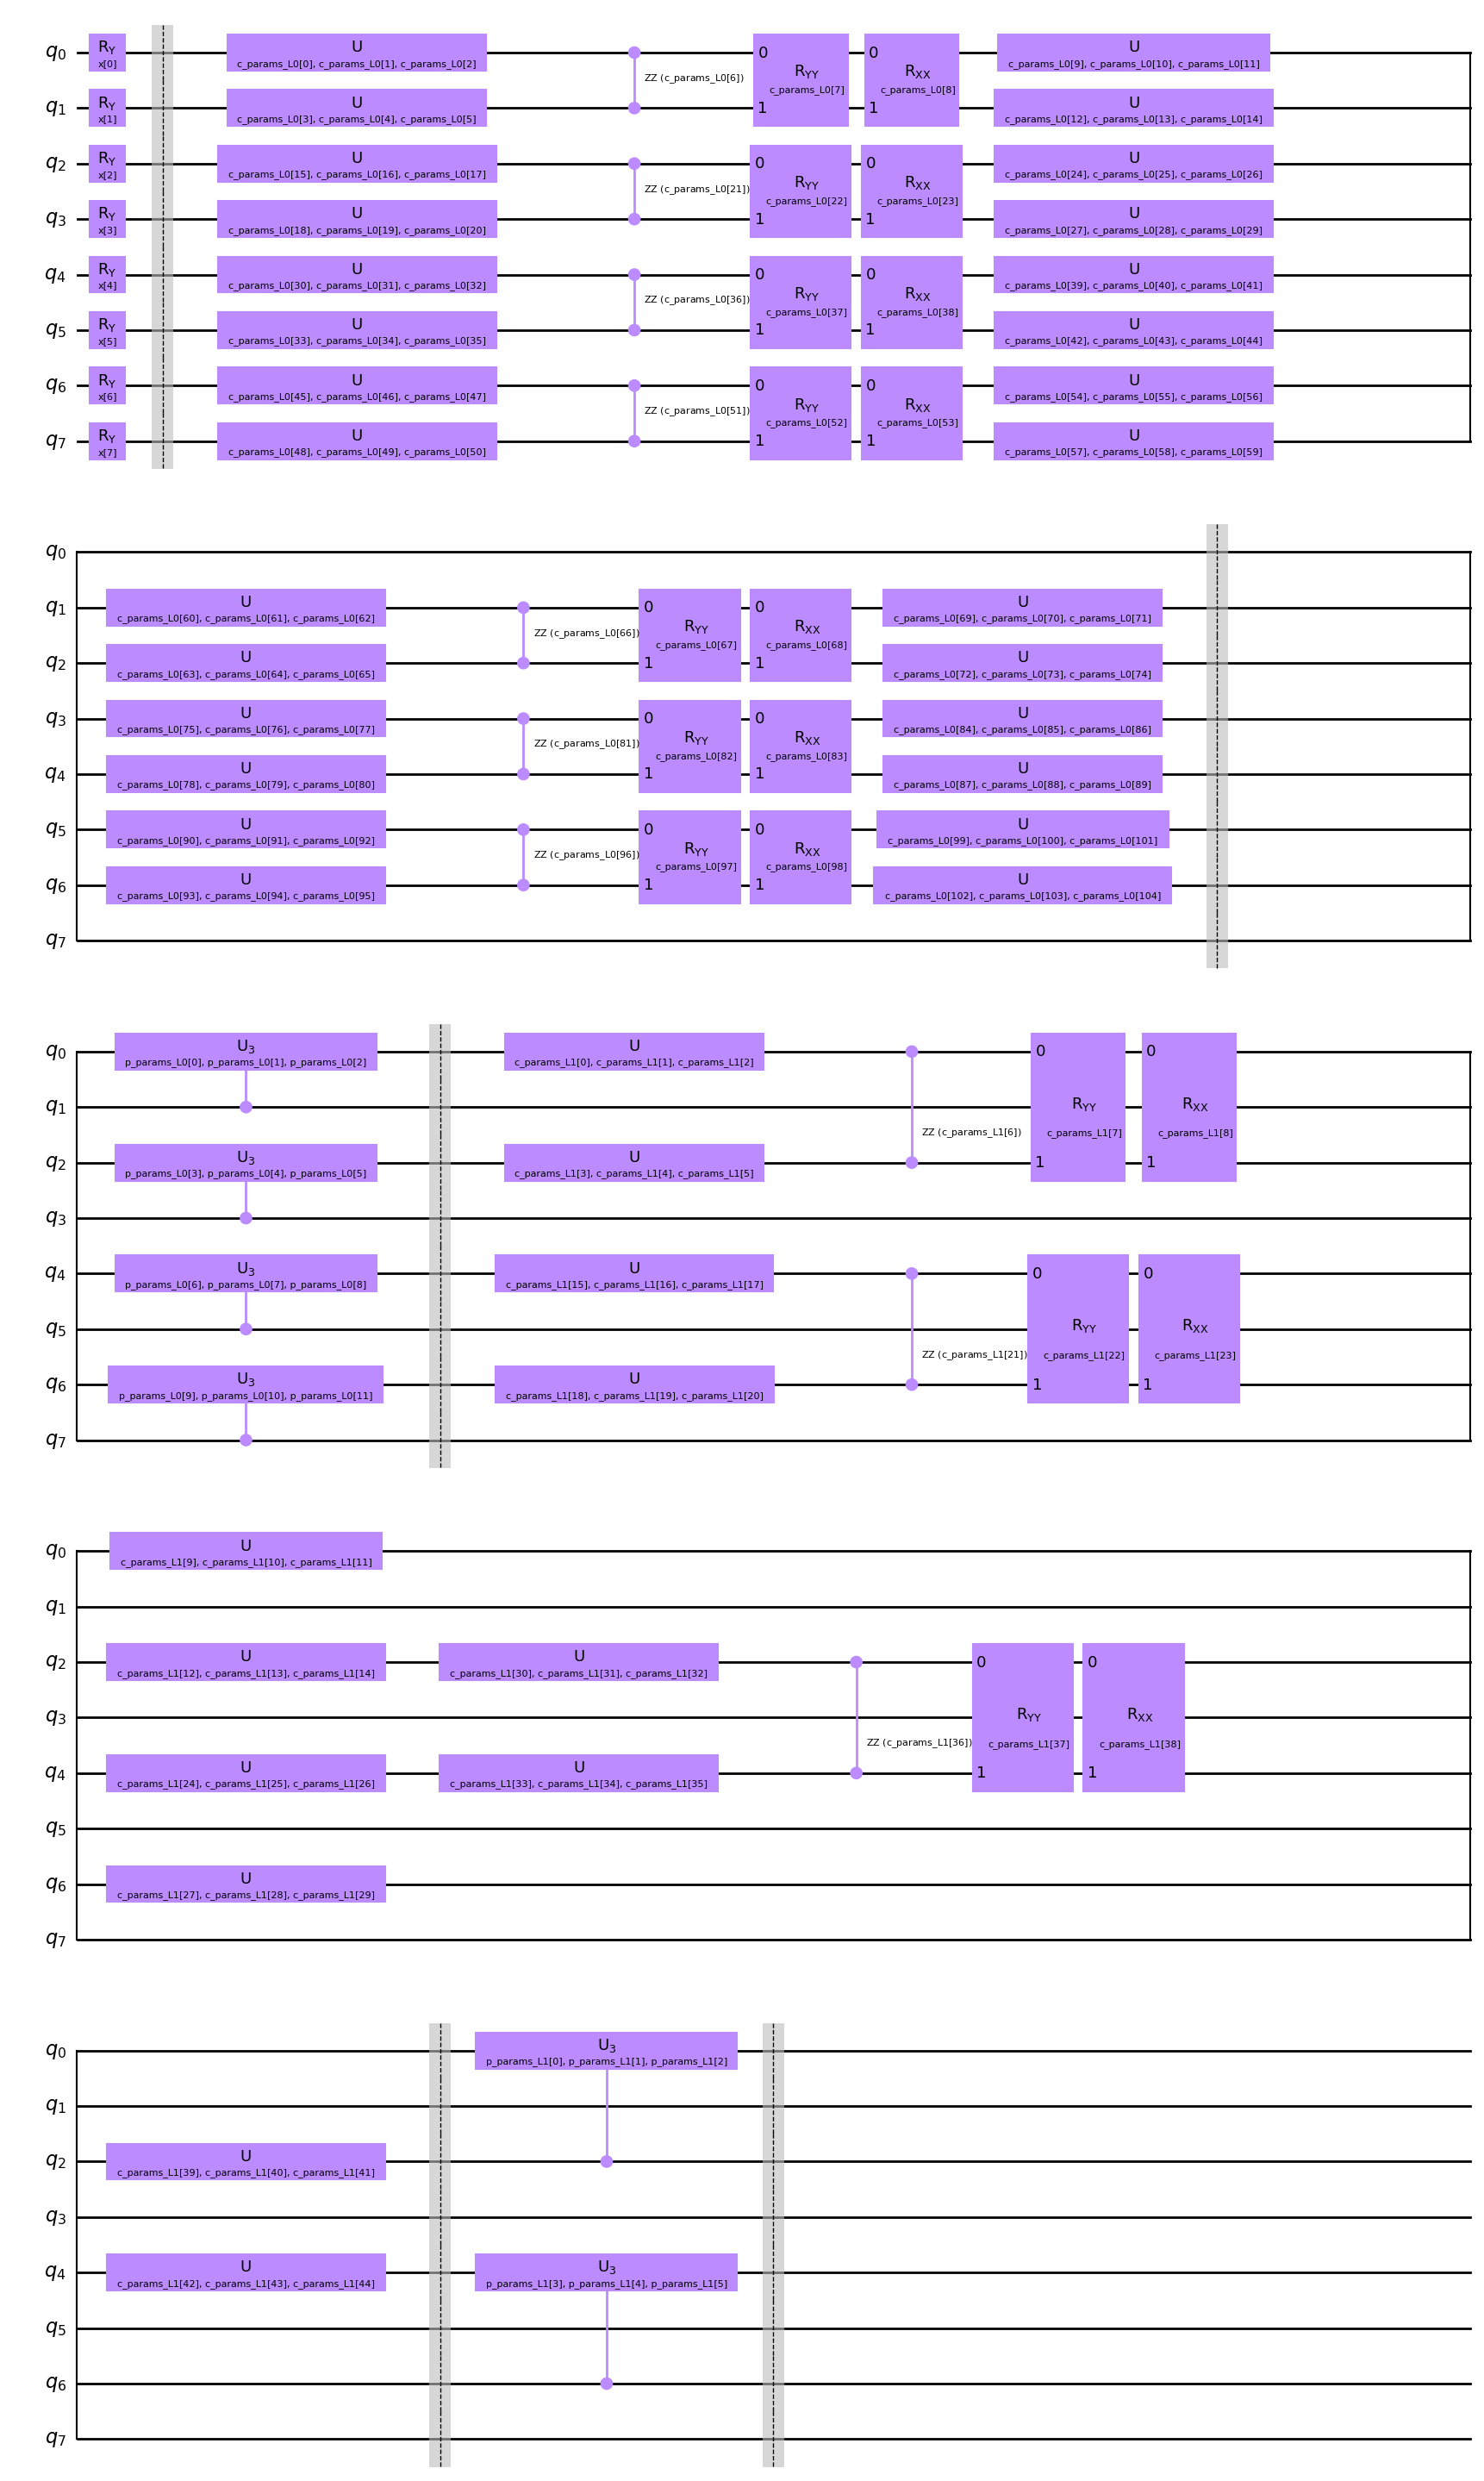

In [16]:
raw_circuit.draw("mpl", style="clifford")

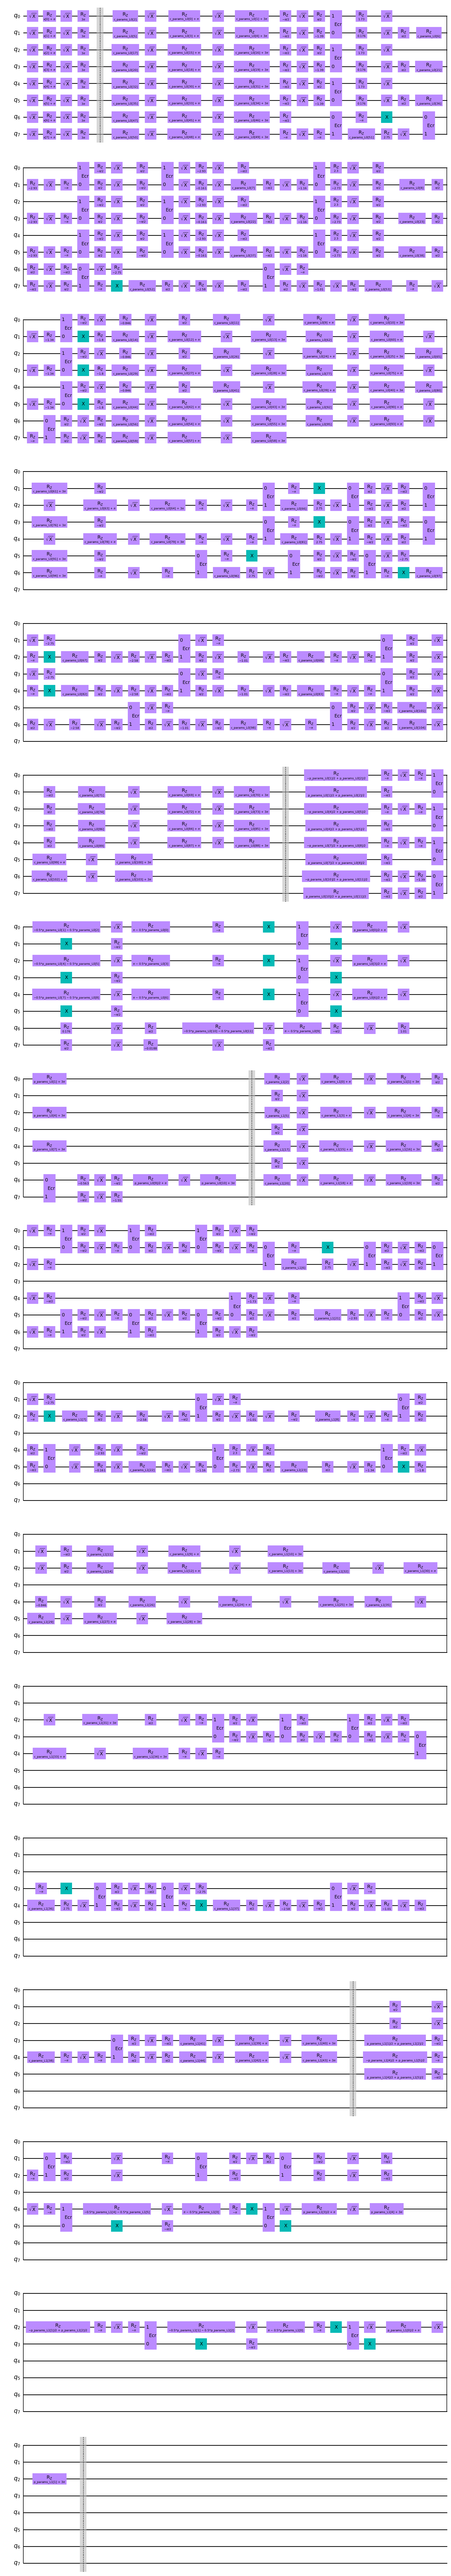

In [17]:
reduced_circuit.draw("mpl", style="clifford")

# MNIST

In [14]:
def load_mnist_multiclass(seed, n_train, n_valtest, device, batch_size):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load dataset with transformation
    transform = Compose([ToTensor(), lambda x: x.view(-1)])  # Flatten MNIST images
    data_train = MNIST(root='./data', train=True, download=True, transform=transform)
    data_test = MNIST(root='./data', train=False, download=True, transform=transform)
    input_dim = 28 * 28

    # Filter for binary classes
    X_train = data_train.data.float() / 255.0  # Normalize pixel values to [0, 1]
    y_train = data_train.targets.clone().detach()
    X_test = data_test.data.float() / 255.0
    y_test = data_test.targets.clone().detach()

    # Binarize labels
    y_train = y_train
    y_test = y_test

    # Shuffle data
    shuffle_idx = torch.randperm(len(y_train))
    X_train = X_train[shuffle_idx]
    y_train = y_train[shuffle_idx]

    shuffle_idx2 = torch.randperm(len(y_test))
    X_test = X_test[shuffle_idx2]
    y_test = y_test[shuffle_idx2]

    # Limit dataset size
    X_train = X_train[:n_train]
    y_train = y_train[:n_train]
    X_test = X_test[:n_valtest]
    y_test = y_test[:n_valtest]    

    # Flatten images
    X_train = X_train.view(-1, 28*28)
    X_test = X_test.view(-1, 28*28)

    # Create TensorDatasets
    train_X = X_train.to(device)
    train_y = y_train.to(device)
    test_X = X_test.to(device)
    test_y = y_test.to(device)

    train_dataset = TensorDataset(train_X, train_y)
    valtest_dataset = TensorDataset(test_X, test_y)

    # Equally split validation and test sets
    val_size = int(0.5 * len(valtest_dataset))
    test_size = len(valtest_dataset) - val_size
    val_dataset, test_dataset = random_split(valtest_dataset, [val_size, test_size])

    # DataLoader parameters
    params = {'shuffle': True, 'batch_size': batch_size} if batch_size > 0 else {'shuffle': True}
    test_params = {'shuffle': False, 'batch_size': batch_size} if batch_size > 0 else {'shuffle': False}

    train_loader = DataLoader(train_dataset, **params)
    val_loader = DataLoader(val_dataset, **test_params)
    test_loader = DataLoader(test_dataset, **test_params)
    
    return train_loader, val_loader, test_loader, input_dim

# Qiskit Simulator to Qiskit Hardware

In [15]:
# Training loop
def train_perf(model, dataloader, optimizer):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    train_loss = 0.0
    all_labels = []
    all_outputs = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Collect labels and outputs for ACC
        all_labels.append(labels.cpu().numpy())
        outputs = torch.argmax(outputs, dim=1)
        all_outputs.append(outputs.detach().cpu().numpy())     

    # Calculate train ACC
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    train_acc = accuracy_score(all_labels, all_outputs)
    
    return train_loss / len(dataloader), train_acc
    

# Validation/Test loop
def evaluate_perf(model, dataloader):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Collect labels and outputs for AUROC
            all_labels.append(labels.cpu().numpy())
            outputs = torch.argmax(outputs, dim=1)
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    acc = accuracy_score(all_labels, all_outputs)
    
    return running_loss / len(dataloader), acc

In [16]:
def Qiskit_Hardware_QCNN_run(seed, device, n_qubits, n_layers, optim_type, num_epochs=10, ckpt_dir="ibmhardware_checkpoints", resume=False):
    """Main function to load model and run hardware evaluation."""
    print(f"Running on {device} & {backend}")
    set_all_seeds(seed)
    # session, estimator = build_runtime_estimator(resilience_level=2)
    opts = EstimatorOptions(default_shots=2000, resilience_level=2) # ZNE & readout mitigation level
    estimator = EstimatorV2(mode=backend, options=opts)
    
    # Path to the checkpoint from the simulator run
    ckpt_path = Path(f"Qiskit_QCNN_simulator_MNIST_multiclass_{optim_type}_checkpoint.pt")
    if not ckpt_path.is_file():
        print(f"Error: Checkpoint file not found at {ckpt_path}")
        print("Please run the simulator notebook first to generate the trained model file.")
        return

    print("Initializing model for hardware backend...")
    model = HybridQCNN(
        seed=seed, n_qubits=n_qubits, n_layers=n_layers, 
        input_dim=input_dim, 
        estimator=estimator
    ).to(device)
        
    # --- LOADING THE TRAINED PARAMETERS ---
    print(f"Loading trained parameters from: {ckpt_path}")
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    # -----------------------------------------------------------
        
    Path(ckpt_dir).mkdir(exist_ok=True)
    ckpt_file = f"Qiskit_QCNN_IBMHardware_MNIST_multiclass_{optim_type}_checkpoint.pt"

    if optim_type == "Adam":
        optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4, eps=1e-8)
                
    # resume if requested and checkpoint exists
    train_metrics, valid_metrics = [], []
    start_epoch = 0
    if resume and os.path.isfile(ckpt_file):
        start_epoch, train_metrics, valid_metrics = load_ckpt(
            ckpt_file, model, optimizer
        )
        print(f"→ Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        t0 = time.time()

        if optim_type == "Adam":
            # optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4, eps=1e-8)
            tr_loss, tr_auc = train_perf(model, train_loader, optimizer)
        elif optim_type == "COBYLA":
            tr_loss, tr_auc = train_perf_cobyla_scipy(model, train_loader, device, maxiter=200)
        va_loss, va_auc = evaluate_perf(model, val_loader)

        train_metrics.append(
            dict(epoch=epoch + 1, train_loss=tr_loss, train_auc=tr_auc)
        )
        valid_metrics.append(
            dict(epoch=epoch + 1, valid_loss=va_loss, valid_auc=va_auc)
        )

        save_ckpt(ckpt_file, epoch, model, optimizer,
                  train_metrics, valid_metrics)

        mins, secs = epoch_time(t0, time.time())
        print(
            f"[{epoch+1:02}/{num_epochs}] {mins}m{secs}s  "
            f"train loss = {tr_loss:.4f} acc = {tr_auc:.4f}  "
            f"val loss = {va_loss:.4f} acc = {va_auc:.4f}"
        )

    # — final test pass —
    te_loss, te_auc = evaluate_perf(model, test_loader)
    
    # session.close()
    print(f"TEST  Loss = {te_loss:.4f}  Acc = {te_auc:.4f}")
    
    # write CSV incrementally (over-writes each time)
    all_rows = []
    for e in range(len(train_metrics)):
        all_rows.append({
            **train_metrics[e],
            **valid_metrics[e],
            "test_loss": te_loss,
            "test_auc": te_auc,
        })
    pd.DataFrame(all_rows).to_csv(
        f"Qiskit_QCNN_IBMHardware_MNIST_multiclass_{optim_type}.csv",
        index=False
    )
    
    return te_loss, te_auc

# Run on Qiskit Hardware: MNIST

In [17]:
train_loader, val_loader, test_loader, input_dim = load_mnist_multiclass(seed=2025, n_train=420, n_valtest=180, device=device, batch_size=32)

In [19]:
Qiskit_Hardware_QCNN_run(seed=2025, device=device, n_qubits=8, n_layers=2, optim_type="Adam", num_epochs=32, resume=True)

Running on cuda & <IBMBackend('ibm_yonsei')>
Initializing model for hardware backend...


/tmp/ipykernel_761061/1516816086.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


Circuit Depth of Transpiled Circuit:  258
Circuit Depth of Reduced Circuit:  258
Loading trained parameters from: Qiskit_QCNN_simulator_MNIST_multiclass_Adam_checkpoint.pt


/global/homes/j/junghoon/.local/perlmutter/python-3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1102: UserWarning: The backend ibm_yonsei currently has a status of internal.
  warnings.warn(
  0%|          | 0/14 [10:37:53<?, ?it/s]


RuntimeJobFailureError: "Unable to retrieve job result. Error code 1500; Failed to execute program: 'Internal error. -- Try again or contact support. -- https://ibm.biz/error_codes#1500"